In [97]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.transform import resize
from skimage import io
from particle_model import Particle, Sphere
import json  # import the library that stores the particle configurations

with open('particle_configurations.json') as f:
    configurations = json.load(f)

In [98]:
# This function creates and initializes particles based on the configuration provided
def create_particle(name):
    # retrieve configuration from the library by name
    configuration = configurations[name]
    p = Particle()  # instantiate a particle object

    # instantiate sphere objects
    for sphere_config in configuration:
        s = Sphere(sphere_config["center"], sphere_config["radius"], sphere_config["color"], sphere_config["material"])
        p.add_sphere(s)

    return p

# This function visualizes the particle in 3D interactive domain
def plot_particle(particle, name, ax, transparency=False):
    min_val = np.inf
    max_val = -np.inf

    for s in particle.spheres:
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = s.center[0] + s.radius * np.outer(np.cos(u), np.sin(v))
        y = s.center[1] + s.radius * np.outer(np.sin(u), np.sin(v))
        z = s.center[2] + s.radius * np.outer(np.ones(np.size(u)), np.cos(v))

        min_val = min(min_val, np.min(x), np.min(y), np.min(z))
        max_val = max(max_val, np.max(x), np.max(y), np.max(z))

        ax.plot_surface(x, y, z, color=s.color, alpha=0.5 if transparency else 1)

    # Plot center of mass
    com = particle.center_of_mass
    mass_center = ax.scatter(com[0], com[1], com[2], color="r", s=30, marker='*')

    # Plot center of geometry
    cog = particle.center_of_geometry
    geometry_center = ax.scatter(cog[0], cog[1], cog[2], color="k", s=30, marker='x')

    # Create legend
    ax.legend([mass_center, geometry_center], ['Center of Mass', 'Geometric Center'])

    # Set title and capitalize each word as well as the element name
    title = name.title()
    ax.set_title(title + f", $\\chi={particle.offset:.2f}$, $\\theta={particle.theta}^o$, $\\phi={particle.phi}^o$")

    ax.set_xlim3d([min_val, max_val])
    ax.set_ylim3d([min_val, max_val])
    ax.set_zlim3d([min_val, max_val])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_box_aspect([1,1,1])

In [99]:
def plot_motion(data, ax):
    # Create a GridSpec for the 4 plots within the given Axes
    gs_inner = mpl.gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=ax, hspace=0.4)

    # Create 4 sub-axes in the provided ax, but use different variable names
    axa = plt.subplot(gs_inner[0])
    axb = plt.subplot(gs_inner[1], sharex=axa)
    axc = plt.subplot(gs_inner[2], sharex=axa)
    axd = plt.subplot(gs_inner[3], sharex=axa)

    # Calculate the velocities
    x_velocity = np.abs(np.diff(data['x']))
    y_velocity = np.abs(np.diff(-data['y']))

    # Calculate average velocities
    avg_x_velocity = np.mean(x_velocity)
    avg_y_velocity = np.mean(y_velocity)

    # Original x displacement plot
    axa.scatter(data['frame'], data['x'], marker='+')
    axa.set_ylabel("x")
    axa.label_outer()  # Hide x tick labels

    # Original y displacement plot
    axb.scatter(data['frame'], -data['y'], marker='+')
    axb.set_ylabel("y")
    axb.label_outer()  # Hide x tick labels

    # New x velocity plot
    axc.scatter(data['frame'][:-1], x_velocity, marker='+', label='Data')
    axc.axhline(y=avg_x_velocity, color='r', linestyle='--', label='Average')
    axc.set_ylabel("$|V_x|$")
    axc.legend()
    axc.label_outer()  # Hide x tick labels

    # New y velocity plot
    axd.scatter(data['frame'][:-1], y_velocity, marker='+', label='Data')
    axd.axhline(y=avg_y_velocity, color='r', linestyle='--', label='Average')
    axd.set_ylabel("$|V_y|$")
    axd.legend()

    # Now, we only want one x label for all the plots, so we set it for the last subplot
    axd.set_xlabel("Frames")

In [100]:
def plot_stacked_image(frames, ax):
    # Number of total frames
    total_frames = frames.shape[0]

    # Calculate the interval at which to take slices
    interval = total_frames // 25

    # Select 25 evenly distributed slices from the stack
    selected_frames = frames[::interval]

    # Maximum Intensity Projection of original selected frames
    mip_selected = np.max(selected_frames, axis=0)

    # Display the stacked image
    ax.imshow(mip_selected, cmap='gray')
    ax.set_title('Stacked Image')
    ax.axis('off')

    return mip_selected  # return this so it can be used in the stretched image function


def plot_stretched_image(mip_selected, ax):
    # Define a new width for the stretched image (e.g., ten times the original width)
    new_width = mip_selected.shape[1] * 20  # change the multiplier as needed

    # Resize the image
    stretched_image = resize(mip_selected, (mip_selected.shape[0], new_width))

    # Display the stretched image
    ax.imshow(stretched_image, cmap='gray', aspect='auto')
    ax.set_title('Stretched Image')
    ax.axis('off')

In [101]:
glacier_path = 'Z:\Mingxuan Liu'
folder_name = '3steel&1copper_SteelUp_chiral_10_6fps'
config_name = "tetramer-st-cu"  # name of the configuration

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


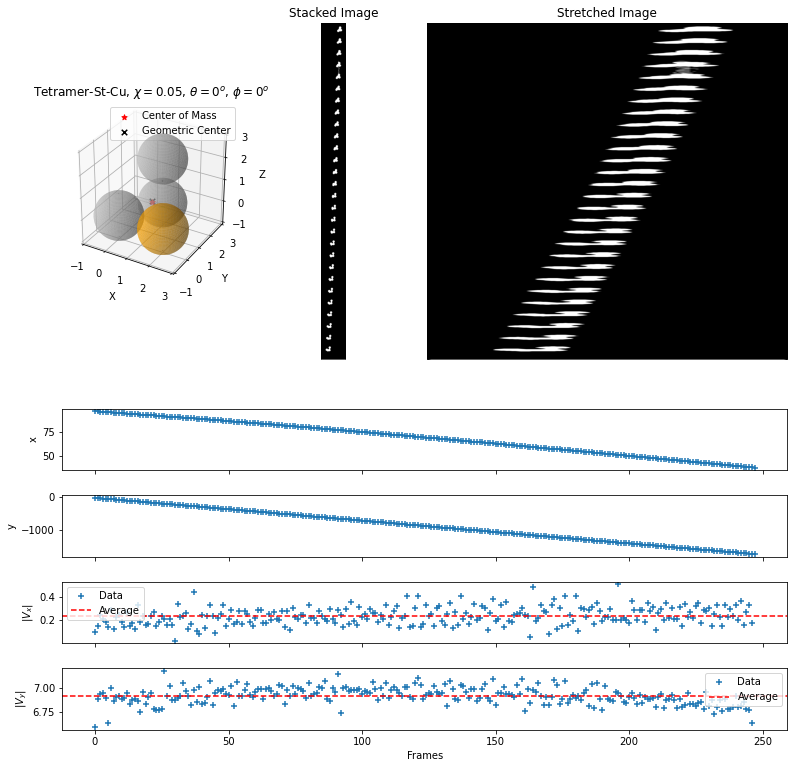

In [103]:
# Create a GridSpec object
fig = plt.figure(figsize=(13, 13))
gs = gridspec.GridSpec(2, 4)  # Changed from 3 to 4

# Create subplots
ax1 = plt.subplot(gs[0, 0], projection='3d')  # Top left for 3D particle
ax2 = plt.subplot(gs[0, 1])  # Top middle for the stacked image
ax3 = plt.subplot(gs[0, 2:4])  # Top right for the stretched image, it now spans 2 columns
ax4 = plt.subplot(gs[1, :])  # Bottom for stacked and stretched image

# Plot in each subplot
# 1. Plot the 3D particle model
p = create_particle(config_name)
plot_particle(p, config_name, ax=ax1, transparency=True)

# 2. Plot the stacked and stretched image
tif_path = os.path.join(glacier_path, folder_name, folder_name + ' binary crop.tif')
frames = io.imread(tif_path)
stacked_image = plot_stacked_image(frames, ax=ax2)
plot_stretched_image(stacked_image, ax=ax3)

# 3. Plot the motion
tracking_data = pd.read_csv(os.path.join(glacier_path, folder_name, folder_name + ' binary.csv'))
plot_motion(tracking_data, ax=ax4)

# Manually adjust the layout
fig.subplots_adjust(hspace=0.1, wspace=0.025)

# Save the figure
plt.savefig("test.png", dpi=300, bbox_inches='tight')

# Finally, show the plot
plt.show()